In [1]:
import pandas as pd, json, pathlib, itertools, collections
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm.auto import tqdm
import plotly.express as px
import plotly.graph_objects as go
import imageio.v2 as imageio
from pathlib import Path
from natsort import natsorted     

In [4]:
import pandas as pd
import json
from pathlib import Path

# Paths to data folders and files
DATA_ROOT   = Path('results')                # Root directory for outputs
COMM_PATH   = DATA_ROOT / 'communities'      # Folder with community .jsons
PERF_CSV    = DATA_ROOT / 'performance.csv'  # Rolling performance log
PORT_JSON   = DATA_ROOT / 'portfolios.json'  # Portfolio weights

# Load each community .json file as a partition dict
def load_partitions(path=COMM_PATH):
    parts = {}
    for p in sorted(path.glob('*.json')):
        date = pd.to_datetime(p.stem)              # extract date from filename
        parts[date] = json.loads(p.read_text())    # load dict of {ticker: community_id}
    return pd.Series(parts, name='partition').sort_index()

# Load all artefacts
partitions = load_partitions()
performance = pd.read_csv(PERF_CSV, parse_dates=['date'])

with open(PORT_JSON) as fp:
    portfolios = json.load(fp)

# Correct way to count unique community IDs in a partition dict
print(f'{len(partitions)} time windows')
print(f'Communities per window: {len(set(partitions.iloc[0].values()))} – {len(set(partitions.iloc[-1].values()))}')

497 time windows
Communities per window: 10 – 11


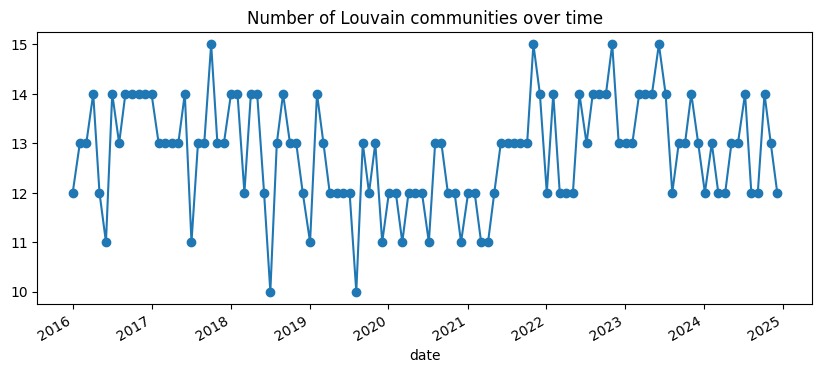

In [5]:
# number of communities over time
perf = performance.set_index('date').join(
    partitions.apply(lambda d: len(set(d.values()))).rename('n_comm_from_file')
)
perf[['n_comm','n_comm_from_file']].head()

plt.figure(figsize=(10,4))
perf['n_comm_from_file'].plot(marker='o')
plt.title('Number of Louvain communities over time')
plt.show()


0it [00:00, ?it/s]

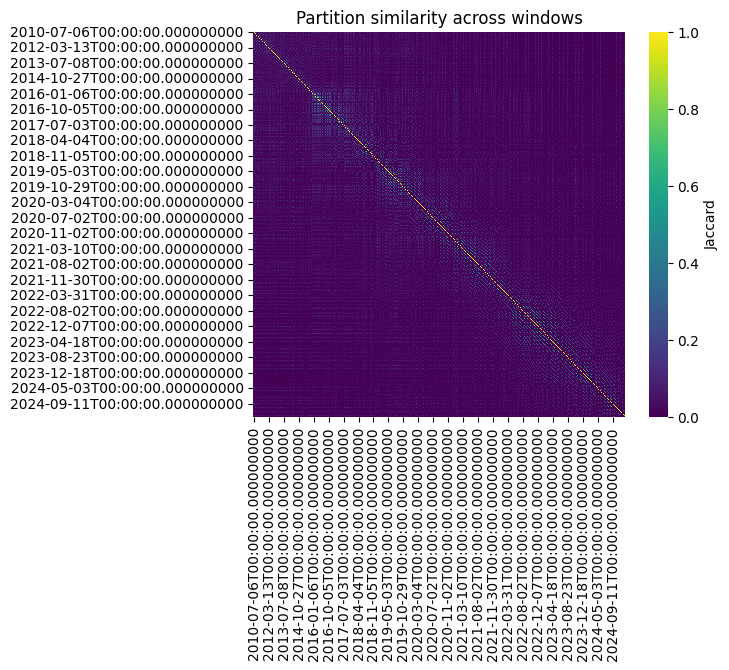

In [7]:
from itertools import combinations
import numpy as np

# pairwise Jaccard similarity between consecutive partitions
def jaccard(a,b):
    return len(a&b)/len(a|b) if a or b else 1.0

# Build similarity matrix
idx = partitions.index
sim = pd.DataFrame(index=idx, columns=idx, dtype=float)
for i,j in tqdm(combinations(range(len(idx)),2)):
    pi, pj = partitions.iloc[i], partitions.iloc[j]
    # flatten sets
    nodes = set(pi.keys()) & set(pj.keys())
    if not nodes:
        v = 0.0
    else:
        v = jaccard(set((pi[k],k) for k in nodes), set((pj[k],k) for k in nodes))
    sim.iat[i,j] = sim.iat[j,i] = v
sim.values[np.diag_indices_from(sim)] = 1.0

plt.figure(figsize=(6,5))
sns.heatmap(sim, cmap='viridis', cbar_kws={'label':'Jaccard'}, xticklabels=20, yticklabels=20)
plt.title('Partition similarity across windows')
plt.show()


In [235]:
# # Build dataframe: index=date, columns=community id, value=size
# sizes = pd.DataFrame({
#     d: pd.Series(collections.Counter(p.values()))
#     for d,p in partitions.items()
# }).T.fillna(0).astype(int)

# sizes.plot(figsize=(12,5))
# plt.title('Community sizes through time')
# plt.legend(bbox_to_anchor=(1.05,1))
# plt.show()


In [237]:
# # Example: plot PnL and portfolio sparsity
# perf['pnl'].plot(figsize=(10,4), title='Forward H‑day PnL')
# plt.show()

# w_counts = pd.Series({d: len(w) for d,w in portfolios.items()})
# w_counts.plot(style='o-')
# plt.title('Number of assets in min‑var peripheral portfolio')
# plt.show()


In [9]:
from collections import defaultdict
import pandas as pd
import plotly.graph_objects as go
import json
from pathlib import Path

# Load partitions with proper datetime index
COMM_PATH = Path("results/communities")
parts = {}
for p in sorted(COMM_PATH.glob("*.json")):
    date = pd.to_datetime(p.stem)
    with open(p) as fp:
        parts[date] = json.load(fp)
partitions = pd.Series(parts, name="partition")
partitions.index = pd.to_datetime(partitions.index)  # Ensure datetime index

# Build Sankey data for a given year
def build_sankey_data(partitions, year):
    year_parts = partitions[partitions.index.year == year]
    if len(year_parts) < 2:
        return None

    labels = []
    index_map = {}
    flows = defaultdict(int)

    # Generate node labels
    for t_idx, (t, part) in enumerate(year_parts.items()):
        for stock, cid in part.items():
            label = f"{t.strftime('%b')}-{cid}"
            if label not in index_map:
                index_map[label] = len(labels)
                labels.append(label)

    # Flow between consecutive windows
    for (t1, p1), (t2, p2) in zip(year_parts.items(), list(year_parts.items())[1:]):
        comm1 = defaultdict(set)
        comm2 = defaultdict(set)
        for k, v in p1.items():
            comm1[v].add(k)
        for k, v in p2.items():
            comm2[v].add(k)

        for c1, stocks1 in comm1.items():
            for c2, stocks2 in comm2.items():
                inter = stocks1 & stocks2
                if inter:
                    l1 = f"{t1.strftime('%b')}-{c1}"
                    l2 = f"{t2.strftime('%b')}-{c2}"
                    flows[(l1, l2)] += len(inter)

    sources, targets, values = [], [], []
    for (src, tgt), val in flows.items():
        sources.append(index_map[src])
        targets.append(index_map[tgt])
        values.append(val)

    sankey_fig = go.Figure(data=[go.Sankey(
        node=dict(label=labels, pad=15, thickness=20),
        link=dict(source=sources, target=targets, value=values)
    )])
    sankey_fig.update_layout(title_text=f"Community Evolution — {year}", font_size=10)
    return sankey_fig

# Generate and save all Sankey plots
years = sorted(set(partitions.index.map(lambda x: x.year)))
output_paths = []
for year in years:
    fig = build_sankey_data(partitions, year)
    if fig:
        out = Path(f"results/sankey/sankey_communities_{year}.html")
        fig.write_html(str(out))
        output_paths.append(str(out))

output_paths


['results/sankey/sankey_communities_2011.html',
 'results/sankey/sankey_communities_2012.html',
 'results/sankey/sankey_communities_2013.html',
 'results/sankey/sankey_communities_2014.html',
 'results/sankey/sankey_communities_2015.html',
 'results/sankey/sankey_communities_2016.html',
 'results/sankey/sankey_communities_2017.html',
 'results/sankey/sankey_communities_2018.html',
 'results/sankey/sankey_communities_2019.html',
 'results/sankey/sankey_communities_2020.html',
 'results/sankey/sankey_communities_2021.html',
 'results/sankey/sankey_communities_2022.html',
 'results/sankey/sankey_communities_2023.html',
 'results/sankey/sankey_communities_2024.html']

In [10]:
# Load the S&P 500 company info file
company_df = pd.read_csv("data/sp500_companies.csv")

# Preview structure and check available fields
company_df.head(), company_df.columns

(  Exchange Symbol              Shortname               Longname  \
 0      NMS   AAPL             Apple Inc.             Apple Inc.   
 1      NMS   NVDA     NVIDIA Corporation     NVIDIA Corporation   
 2      NMS   MSFT  Microsoft Corporation  Microsoft Corporation   
 3      NMS   AMZN       Amazon.com, Inc.       Amazon.com, Inc.   
 4      NMS  GOOGL          Alphabet Inc.          Alphabet Inc.   
 
                    Sector                        Industry  Currentprice  \
 0              Technology            Consumer Electronics        254.49   
 1              Technology                  Semiconductors        134.70   
 2              Technology       Software - Infrastructure        436.60   
 3       Consumer Cyclical                 Internet Retail        224.92   
 4  Communication Services  Internet Content & Information        191.41   
 
        Marketcap        Ebitda  Revenuegrowth           City State  \
 0  3846819807232  1.346610e+11          0.061      Cupertino

In [11]:
partitions = pd.Series(partitions).sort_index()

In [12]:
partitions = pd.Series(partitions, name="partition")
partitions.index = pd.to_datetime(partitions.index)  # enforce datetime index
partitions = partitions.sort_index()

In [13]:
years = sorted(set(partitions.index.year))

In [14]:
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import json
from pathlib import Path

# Load community partitions
COMM_PATH = Path("results/communities")
partitions = {}
for p in sorted(COMM_PATH.glob("*.json")):
    date = pd.to_datetime(p.stem)
    with open(p) as fp:
        partitions[date] = json.load(fp)
partitions = pd.Series(partitions, name="partition")
partitions.index = pd.to_datetime(partitions.index)
partitions = partitions.sort_index()

# Load sector metadata
company_df = pd.read_csv("data/sp500_companies.csv")
sector_map = {k.upper(): v for k, v in company_df.set_index("Symbol")["Sector"].items()}

# Ensure output folder exists
output_dir = Path("results/sector")
output_dir.mkdir(parents=True, exist_ok=True)

# Generate plots
years = sorted(set(partitions.index.year))
output_paths = []

for year in years:
    year_parts = partitions[partitions.index.year == year]
    n = len(year_parts)
    if n == 0:
        continue

    fig, axes = plt.subplots(nrows=(n + 2) // 3, ncols=3, figsize=(16, 4 * ((n + 2) // 3)))
    axes = axes.flatten()
    last_ax = None

    for ax, (dt, part) in zip(axes, year_parts.items()):
        community_sector_counts = defaultdict(lambda: defaultdict(int))
        for stock, cid in part.items():
            sector = sector_map.get(stock.upper(), "Unknown")
            community_sector_counts[cid][sector] += 1

        df = pd.DataFrame(community_sector_counts).fillna(0).astype(int)
        if df.empty:
            continue

        df = df.reindex(df.sum(axis=1).sort_values(ascending=False).index)

        df.T.plot(kind="bar", stacked=True, ax=ax, width=0.8, colormap="tab20", legend=False)
        ax.set_title(dt.strftime("%Y-%m-%d"))
        ax.set_xlabel("Community ID")
        ax.set_ylabel("Sector count")
        last_ax = ax  # save for shared legend

    for i in range(len(year_parts), len(axes)):
        fig.delaxes(axes[i])

    if last_ax:
        handles, labels = last_ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', ncol=5, fontsize='medium', bbox_to_anchor=(0.5, 1.02))

    fig.suptitle(f"Sector composition by community – {year}", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    out_path = output_dir / f"sector_by_community_{year}.png"
    fig.savefig(out_path)
    plt.close(fig)
    output_paths.append(str(out_path))

output_paths


['results/sector/sector_by_community_2010.png',
 'results/sector/sector_by_community_2011.png',
 'results/sector/sector_by_community_2012.png',
 'results/sector/sector_by_community_2013.png',
 'results/sector/sector_by_community_2014.png',
 'results/sector/sector_by_community_2015.png',
 'results/sector/sector_by_community_2016.png',
 'results/sector/sector_by_community_2017.png',
 'results/sector/sector_by_community_2018.png',
 'results/sector/sector_by_community_2019.png',
 'results/sector/sector_by_community_2020.png',
 'results/sector/sector_by_community_2021.png',
 'results/sector/sector_by_community_2022.png',
 'results/sector/sector_by_community_2023.png',
 'results/sector/sector_by_community_2024.png']

In [15]:
from scipy.stats import entropy

def community_sector_entropy(partition, sector_map):
    cid_sectors = defaultdict(list)
    for stock, cid in partition.items():
        sec = sector_map.get(stock.upper(), "Unknown")
        cid_sectors[cid].append(sec)
    
    return {cid: entropy(pd.Series(secs).value_counts(normalize=True)) 
            for cid, secs in cid_sectors.items()}

In [16]:
# returns: {time: {community_id: {sector: proportion}}}
def sector_proportions(partitions, sector_map):
    result = {}
    for t, part in partitions.items():
        c_table = defaultdict(lambda: defaultdict(int))
        for stock, cid in part.items():
            sec = sector_map.get(stock.upper(), "Unknown")
            c_table[cid][sec] += 1
        # normalize
        c_props = {
            cid: {s: v/sum(secs.values()) for s,v in secs.items()}
            for cid, secs in c_table.items()
        }
        result[t] = c_props
    return result

In [17]:
from collections import Counter

def sector_to_comm_matrix(partitions, sector_map, sector):
    dates = []
    counts = []

    for dt, part in partitions.items():
        comm_counter = Counter()
        for stock, cid in part.items():
            if sector_map.get(stock.upper(), "Unknown") == sector:
                comm_counter[cid] += 1
        dates.append(dt)
        counts.append(comm_counter)

    return pd.DataFrame(counts, index=dates).fillna(0).astype(int)

In [ ]:
from collections import defaultdict

def sector_churn(partitions, sector_map):
    churns = defaultdict(int)
    prev = None
    for part in partitions:
        if prev is None:
            prev = part
            continue
        for stock in prev:
            if stock in part and prev[stock] != part[stock]:
                sector = sector_map.get(stock.upper(), "Unknown")
                churns[sector] += 1
        prev = part
    return pd.Series(churns).sort_values(ascending=False)

In [19]:
# One snapshot
t = partitions.index[0]
entropy_dict = community_sector_entropy(partitions[t], sector_map)
pd.Series(entropy_dict).sort_index()

0    1.608395
1    1.496697
2    1.291906
3    1.956187
4    1.684373
5    1.840749
6    1.215388
7    0.639032
8    0.964963
9    0.000000
dtype: float64

In [20]:
sector_prop = sector_proportions(partitions, sector_map)

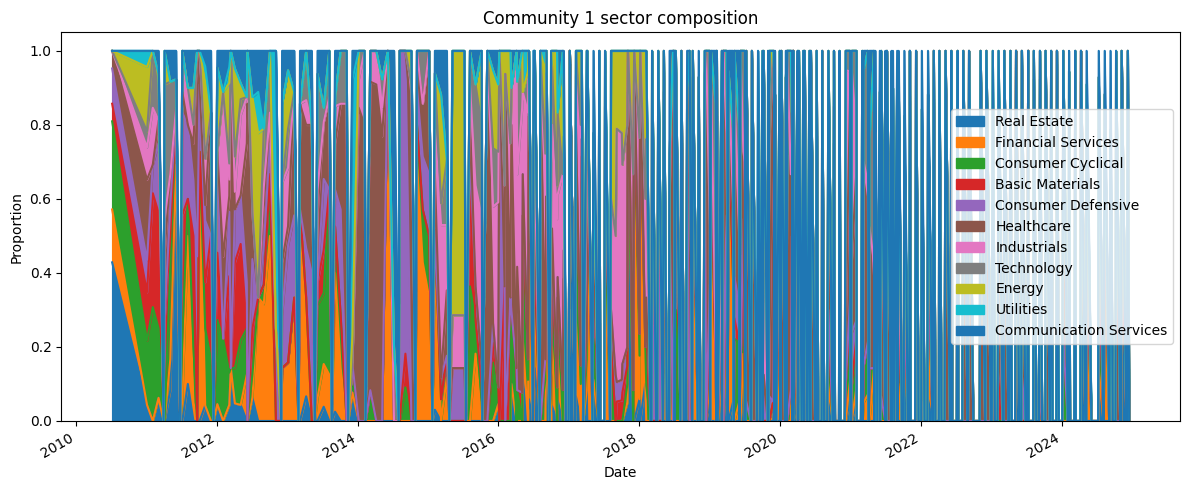

In [21]:
# Get sector proportions for community 0 over time
community_id = 1
df = pd.DataFrame({
    t: props.get(community_id, {}) for t, props in sector_prop.items()
}).T.fillna(0)

df.plot.area(figsize=(12, 5), title=f"Community {community_id} sector composition")
plt.xlabel("Date")
plt.ylabel("Proportion")
plt.tight_layout()
plt.show()

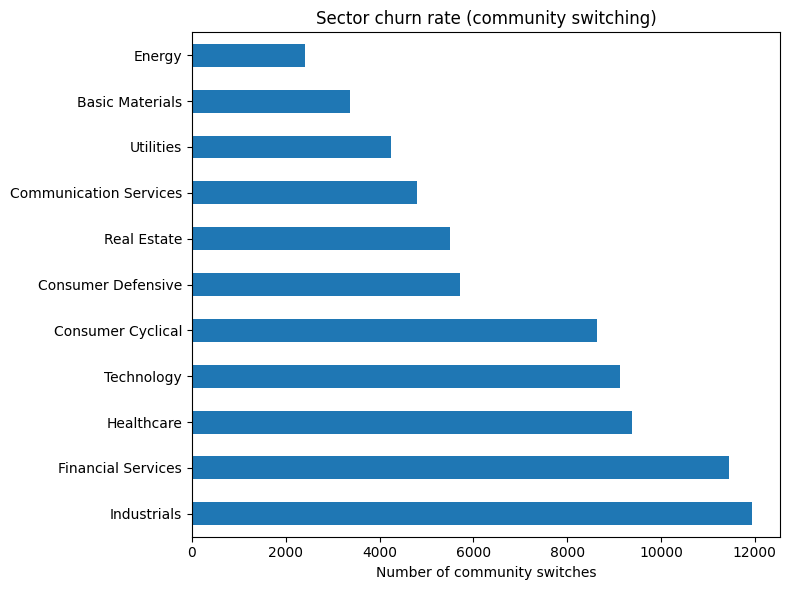

In [22]:
churn = sector_churn(partitions, sector_map)
churn.plot.barh(figsize=(8, 6), title="Sector churn rate (community switching)")
plt.xlabel("Number of community switches")
plt.tight_layout()
plt.show()

In [24]:
import ast

In [25]:
df = pd.read_csv("results/performance.csv")

# Parse date and list-like columns
df['date'] = pd.to_datetime(df['date'])
df['births'] = df['births'].apply(ast.literal_eval)
df['deaths'] = df['deaths'].apply(ast.literal_eval)
df['rebalance'] = df['rebalance'].astype(bool)

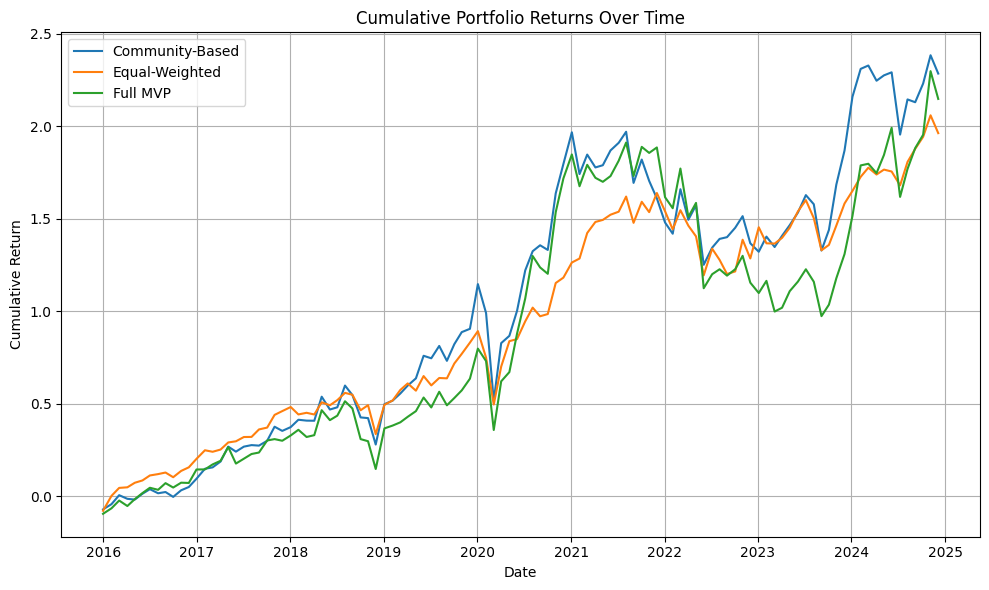

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df['date'], df['cum_comm'], label='Community-Based')
plt.plot(df['date'], df['cum_eq'], label='Equal-Weighted')
plt.plot(df['date'], df['cum_full'], label='Full MVP')
plt.legend()
plt.title('Cumulative Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.tight_layout()
plt.show()

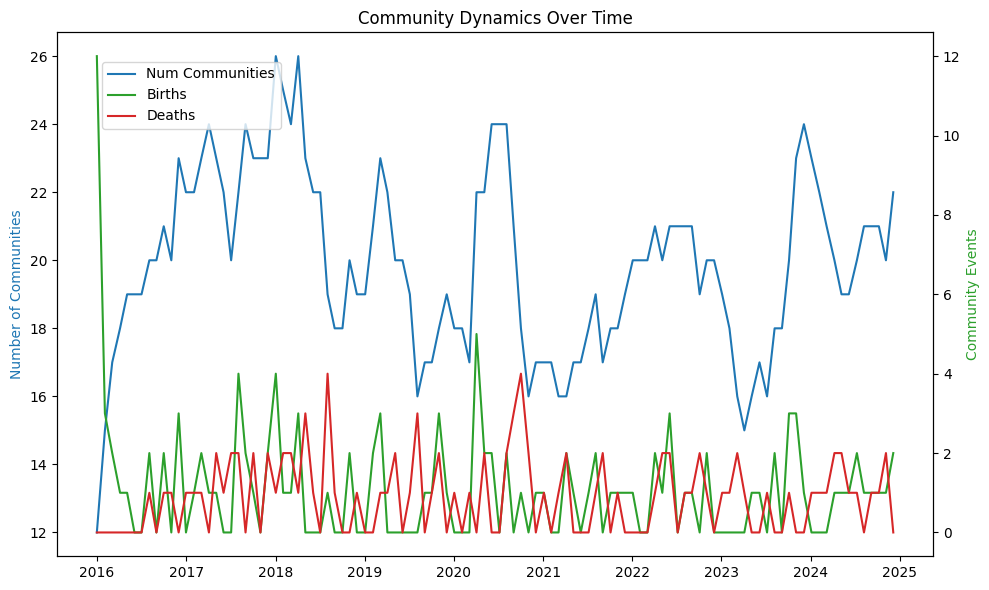

In [27]:
df['n_births'] = df['births'].apply(len)
df['n_deaths'] = df['deaths'].apply(len)

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(df['date'], df['n_comm'], label='Num Communities', color='tab:blue')
ax1.set_ylabel('Number of Communities', color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(df['date'], df['n_births'], label='Births', color='tab:green')
ax2.plot(df['date'], df['n_deaths'], label='Deaths', color='tab:red')
ax2.set_ylabel('Community Events', color='tab:green')
plt.title("Community Dynamics Over Time")
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.tight_layout()
plt.show()

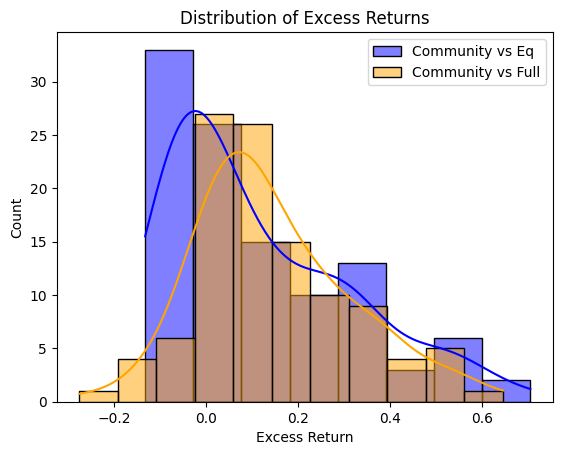

In [28]:
import seaborn as sns

# Distribution of performance differences
sns.histplot(df['act_vs_eq'], kde=True, label='Community vs Eq', color='blue')
sns.histplot(df['act_vs_full'], kde=True, label='Community vs Full', color='orange')
plt.legend()
plt.title("Distribution of Excess Returns")
plt.xlabel("Excess Return")
plt.show()

             r_comm      r_eq    r_full
rebalance                              
True       0.012868  0.011012  0.012778


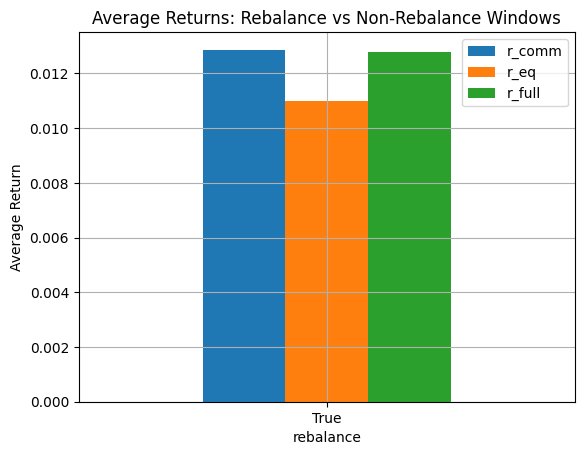

In [29]:
# Average returns on rebalancing vs non-rebalancing days
rebalance_stats = df.groupby('rebalance')[['r_comm', 'r_eq', 'r_full']].mean()
print(rebalance_stats)

# Visualize
rebalance_stats.plot(kind='bar')
plt.title('Average Returns: Rebalance vs Non-Rebalance Windows')
plt.ylabel('Average Return')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

In [30]:
# Lag community changes and correlate
df['births_lag'] = df['n_births'].shift(1)
df['deaths_lag'] = df['n_deaths'].shift(1)

correlations = df[['r_comm', 'r_eq', 'r_full', 'births_lag', 'deaths_lag']].corr()
print(correlations[['r_comm']])

              r_comm
r_comm      1.000000
r_eq        0.802906
r_full      0.925161
births_lag  0.078460
deaths_lag -0.008949


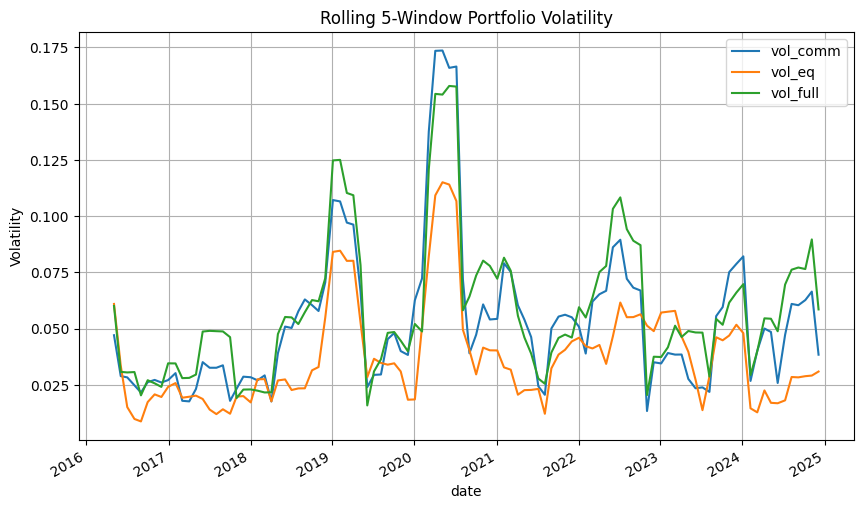

In [31]:
df['vol_comm'] = df['r_comm'].rolling(window=5).std()
df['vol_eq'] = df['r_eq'].rolling(window=5).std()
df['vol_full'] = df['r_full'].rolling(window=5).std()

df[['date', 'vol_comm', 'vol_eq', 'vol_full']].set_index('date').plot(figsize=(10,6))
plt.title('Rolling 5-Window Portfolio Volatility')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

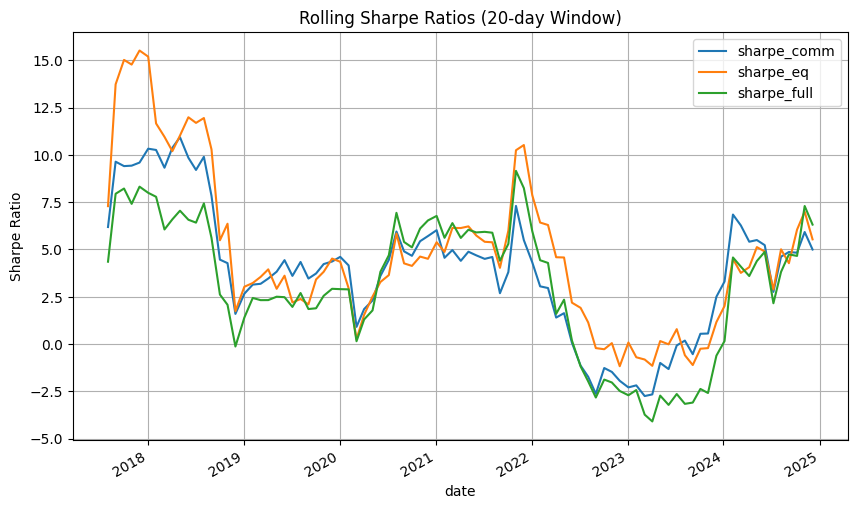

In [32]:
risk_free_rate = 0.0  # Change if needed

# Annualized Sharpe ratios with rolling 20-day windows
roll_window = 20
sharpe = lambda x: (x.mean() - risk_free_rate) / x.std() * (252**0.5)

df['sharpe_comm'] = df['r_comm'].rolling(roll_window).apply(sharpe)
df['sharpe_eq'] = df['r_eq'].rolling(roll_window).apply(sharpe)
df['sharpe_full'] = df['r_full'].rolling(roll_window).apply(sharpe)

df[['date', 'sharpe_comm', 'sharpe_eq', 'sharpe_full']].set_index('date').plot(figsize=(10,6))
plt.title('Rolling Sharpe Ratios (20-day Window)')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()

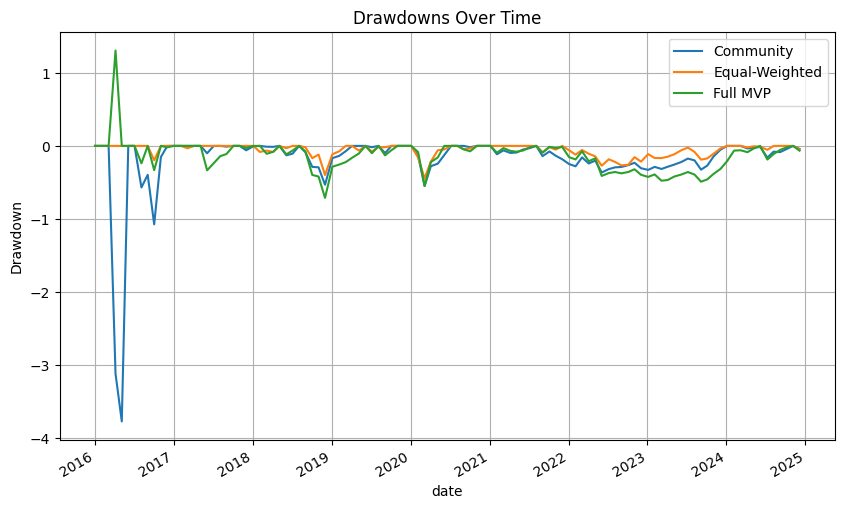

Max Drawdowns:
Community: -377.59%
Equal-Weighted: -44.42%
Full MVP: -71.24%


In [33]:
def compute_drawdown(series):
    cummax = series.cummax()
    dd = series / cummax - 1
    return dd

dd_comm = compute_drawdown(df['cum_comm'])
dd_eq = compute_drawdown(df['cum_eq'])
dd_full = compute_drawdown(df['cum_full'])

pd.DataFrame({
    'date': df['date'],
    'Community': dd_comm,
    'Equal-Weighted': dd_eq,
    'Full MVP': dd_full
}).set_index('date').plot(figsize=(10,6))
plt.title('Drawdowns Over Time')
plt.ylabel('Drawdown')
plt.grid(True)
plt.show()

# Max drawdowns
print("Max Drawdowns:")
print(f"Community: {dd_comm.min():.2%}")
print(f"Equal-Weighted: {dd_eq.min():.2%}")
print(f"Full MVP: {dd_full.min():.2%}")

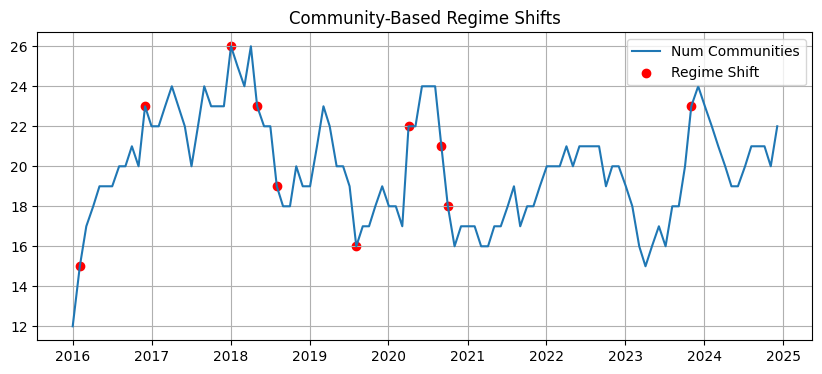

In [34]:
df['n_comm_diff'] = df['n_comm'].diff().fillna(0)
df['regime_shift'] = df['n_comm_diff'].abs() > 2  # heuristic

plt.figure(figsize=(10,4))
plt.plot(df['date'], df['n_comm'], label='Num Communities')
plt.scatter(df['date'][df['regime_shift']], df['n_comm'][df['regime_shift']], color='red', label='Regime Shift')
plt.title('Community-Based Regime Shifts')
plt.legend()
plt.grid(True)
plt.show()

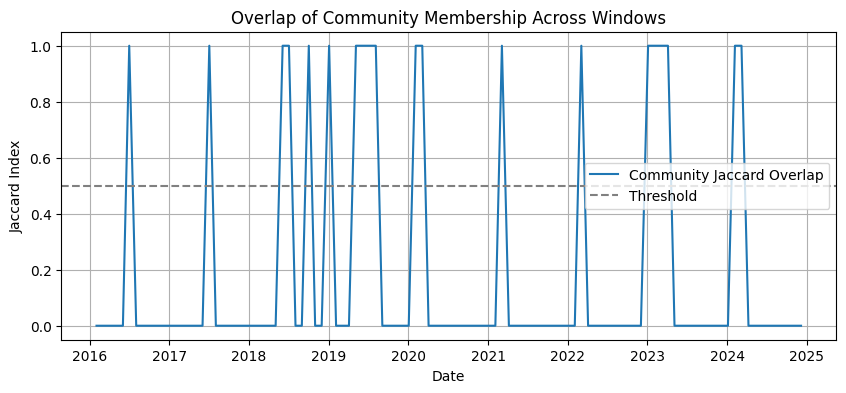

In [35]:
from sklearn.metrics import jaccard_score

# Create Jaccard overlap between consecutive 'births' sets
jaccards = []
for i in range(1, len(df)):
    a = set(df.iloc[i-1]['births'])
    b = set(df.iloc[i]['births'])
    if a or b:
        jaccards.append(len(a & b) / len(a | b))
    else:
        jaccards.append(1.0)  # both empty = full match

df.loc[1:, 'jaccard'] = jaccards

plt.figure(figsize=(10,4))
plt.plot(df['date'], df['jaccard'], label='Community Jaccard Overlap')
plt.axhline(0.5, linestyle='--', color='gray', label='Threshold')
plt.title('Overlap of Community Membership Across Windows')
plt.ylabel('Jaccard Index')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
import os
import json
from collections import defaultdict

# Path to the community folder
community_path = "results/communities"

# Ensure only .json files, sorted by date
files = sorted([
    f for f in os.listdir(community_path)
    if f.endswith('.json') and len(f) == 15  # e.g. '2011-01-03.json'
])

stock_communities = defaultdict(list)
dates = []

for fname in files:
    fpath = os.path.join(community_path, fname)
    try:
        with open(fpath, 'r', encoding='utf-8') as f:
            data = json.load(f)

            # Add community assignment for each stock
            for stock, com in data.items():
                stock_communities[stock].append(com)

            dates.append(fname.replace('.json', ''))

    except (UnicodeDecodeError, json.JSONDecodeError) as e:
        print(f"Skipping file {fname}: {e}")


In [37]:
all_stocks = set(stock_communities.keys())
print(f"{len(all_stocks)} tickers found.\nExample tickers:\n", list(all_stocks)[:20])

161 tickers found.
Example tickers:
 ['SWK', 'LRCX', 'BRO', 'HRL', 'VTRS', 'K', 'LEN', 'PNC', 'IQV', 'WMB', 'PEG', 'TSLA', 'CAT', 'DOV', 'STZ', 'NTAP', 'PKG', 'GPN', 'AMP', 'EA']


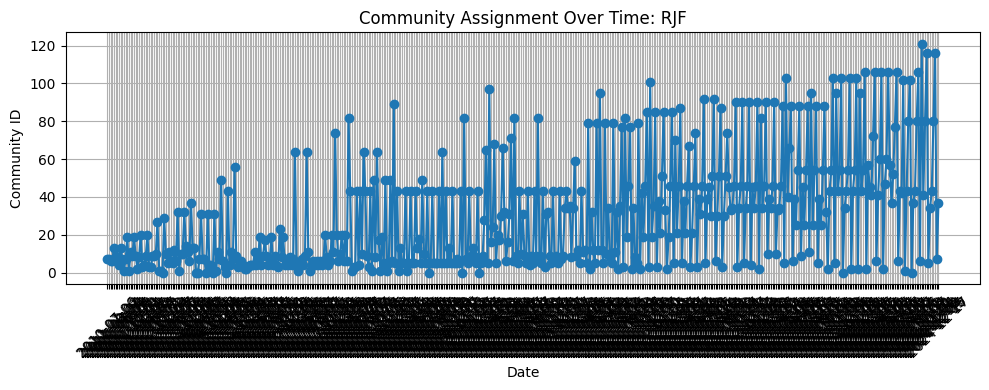

In [38]:
stock = 'RJF'  # Replace as needed
comms = stock_communities.get(stock)

if comms:
    plt.figure(figsize=(10, 4))
    plt.plot(dates, comms, marker='o')
    plt.title(f"Community Assignment Over Time: {stock}")
    plt.ylabel("Community ID")
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"{stock} not found in community assignments.")


In [39]:
from collections import Counter

# For a given stock, get community distribution
stock = 'NVDA'
if stock in stock_communities:
    counts = Counter(stock_communities[stock])
    print(f"Community frequency for {stock}:", dict(counts))
else:
    print(f"{stock} not found.")

Community frequency for NVDA: {6: 46, 10: 12, 4: 23, 11: 8, 0: 17, 1: 8, 5: 15, 9: 22, 3: 1, 8: 21, 7: 39, 33: 1, 38: 8, 15: 14, 23: 18, 14: 3, 48: 3, 45: 2, 39: 2, 12: 11, 2: 6, 16: 6, 55: 9, 18: 3, 21: 9, 19: 3, 73: 1, 27: 1, 36: 6, 67: 1, 46: 3, 77: 5, 47: 3, 32: 9, 13: 3, 53: 1, 56: 21, 25: 5, 51: 2, 26: 5, 93: 11, 76: 7, 43: 22, 80: 9, 50: 2, 102: 6, 78: 27, 30: 5, 37: 13, 58: 14, 70: 1, 65: 1, 108: 1, 120: 1, 63: 1}


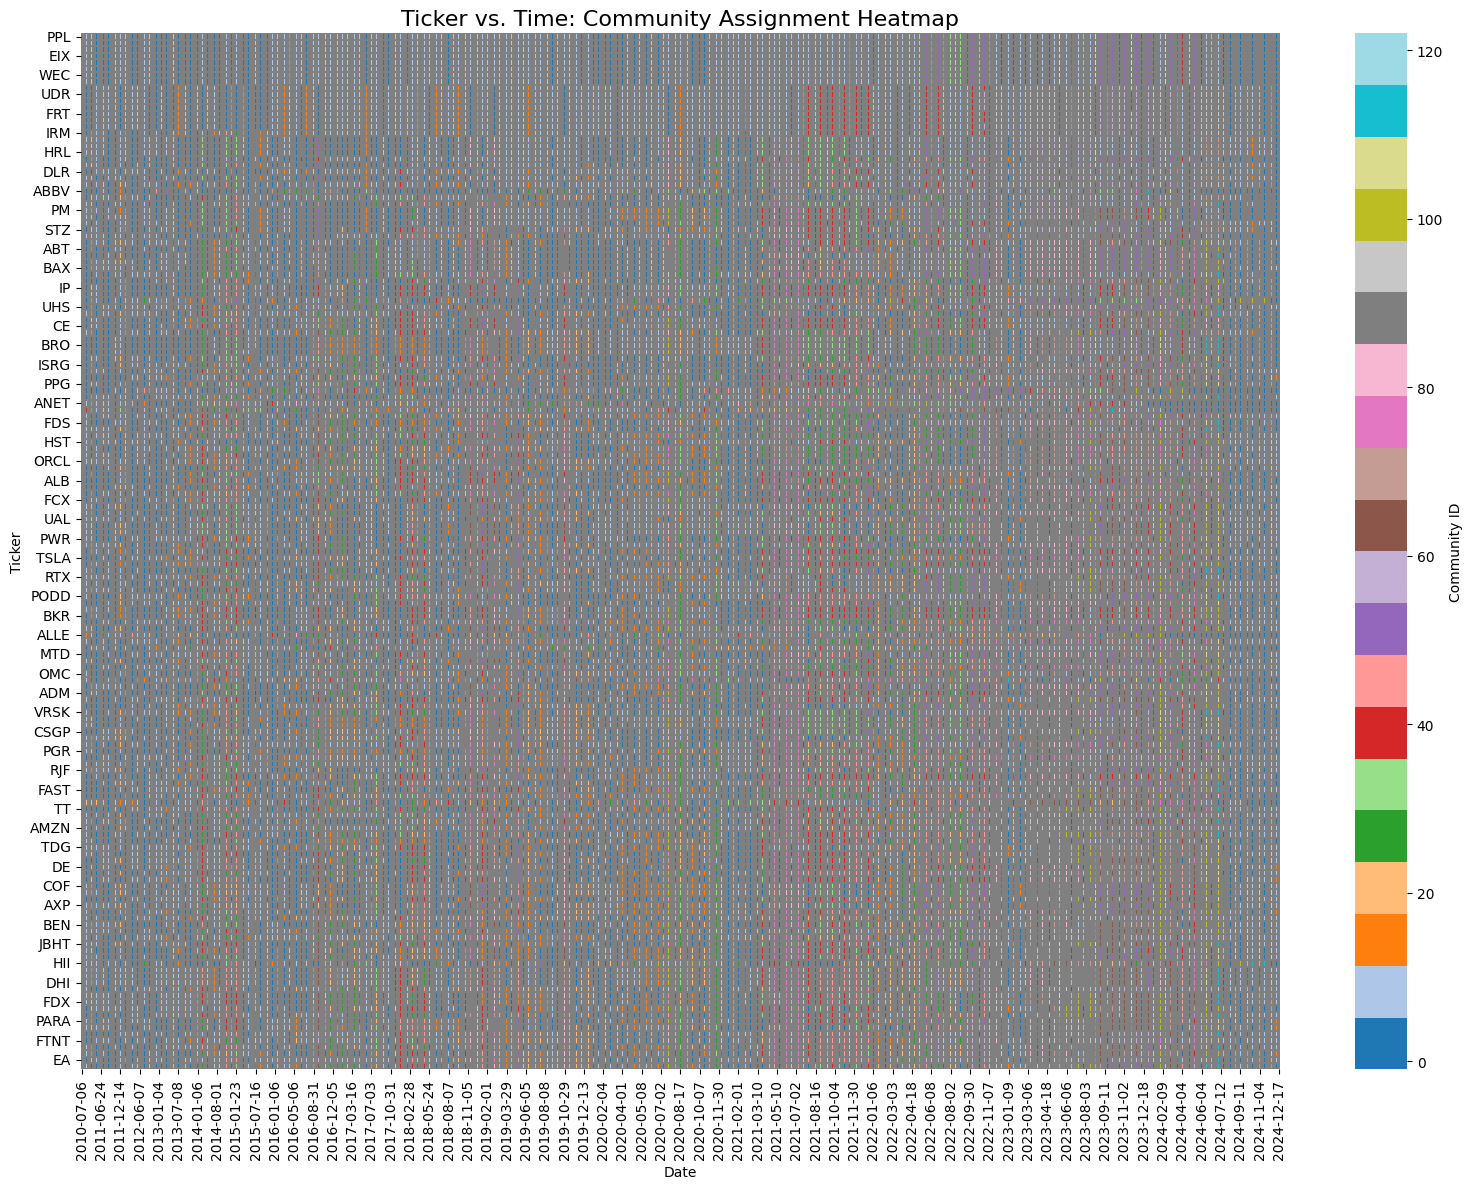

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame: rows = tickers, columns = dates, values = community ID
tickers = sorted(stock_communities.keys())
heatmap_data = pd.DataFrame(index=tickers, columns=dates)

# Fill the DataFrame
for stock in tickers:
    comms = stock_communities[stock]
    for i, com in enumerate(comms):
        heatmap_data.at[stock, dates[i]] = com

# Convert to numeric and sort by similarity of community history
heatmap_data = heatmap_data.astype(float).fillna(-1)  # -1 for missing (not present)
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values().index]  # optional: reorder rows

# Plot
plt.figure(figsize=(16, 12))
sns.heatmap(
    heatmap_data,
    cmap="tab20",  # distinct colors per community
    cbar_kws={'label': 'Community ID'},
    linewidths=0.1,
    linecolor='gray'
)

plt.title("Ticker vs. Time: Community Assignment Heatmap", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Ticker")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [41]:
from collections import Counter

persistence_scores = {}
for stock, comms in stock_communities.items():
    counts = Counter(comms)
    mode_com = counts.most_common(1)[0][1]
    score = mode_com / len(comms)
    persistence_scores[stock] = score

# Create a DataFrame and sort
persistence_df = pd.DataFrame.from_dict(persistence_scores, orient='index', columns=['persistence'])
persistence_df = persistence_df.sort_values('persistence', ascending=False)
print(persistence_df.head(10))  # most persistent

      persistence
ABBV     0.260776
WELL     0.233400
FRT      0.233400
KIM      0.233400
ESS      0.227364
EQR      0.227364
IRM      0.227364
UDR      0.227364
O        0.225352
EIX      0.223340


/var/folders/q8/7ss60v9d2t91mvvwbkcjcd3h0000gn/T/ipykernel_49711/3211637694.py:18: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.013284341435839458' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/q8/7ss60v9d2t91mvvwbkcjcd3h0000gn/T/ipykernel_49711/3211637694.py:18: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.03617863199547767' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/q8/7ss60v9d2t91mvvwbkcjcd3h0000gn/T/ipykernel_49711/3211637694.py:18: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.008762012436404749' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/q8/7ss60v9d2t91mvvwbkcjcd3h0000gn/T/ipykernel_49711/

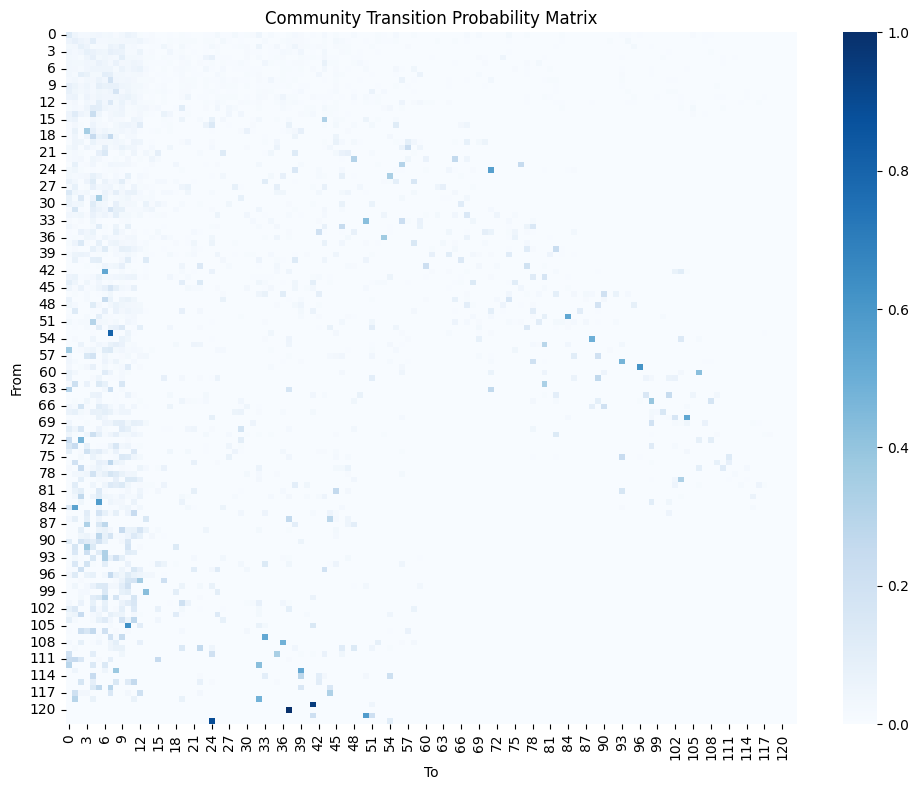

In [42]:
import numpy as np
from collections import defaultdict

# Count transitions
transition_counts = defaultdict(lambda: defaultdict(int))

for comms in stock_communities.values():
    for a, b in zip(comms, comms[1:]):
        transition_counts[a][b] += 1

# Normalize to get transition probabilities
all_comms = sorted(set(k for d in transition_counts.values() for k in d) | set(transition_counts.keys()))
trans_mat = pd.DataFrame(index=all_comms, columns=all_comms).fillna(0)

for from_c in transition_counts:
    total = sum(transition_counts[from_c].values())
    for to_c in transition_counts[from_c]:
        trans_mat.at[from_c, to_c] = transition_counts[from_c][to_c] / total

# Optional: visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(trans_mat.astype(float), cmap="Blues", annot=False)
plt.title("Community Transition Probability Matrix")
plt.xlabel("To")
plt.ylabel("From")
plt.tight_layout()
plt.show()

In [43]:
sector_df = pd.read_csv('data/sp500_companies.csv')

In [44]:
sector_map = dict(zip(sector_df['Symbol'], sector_df['Sector']))

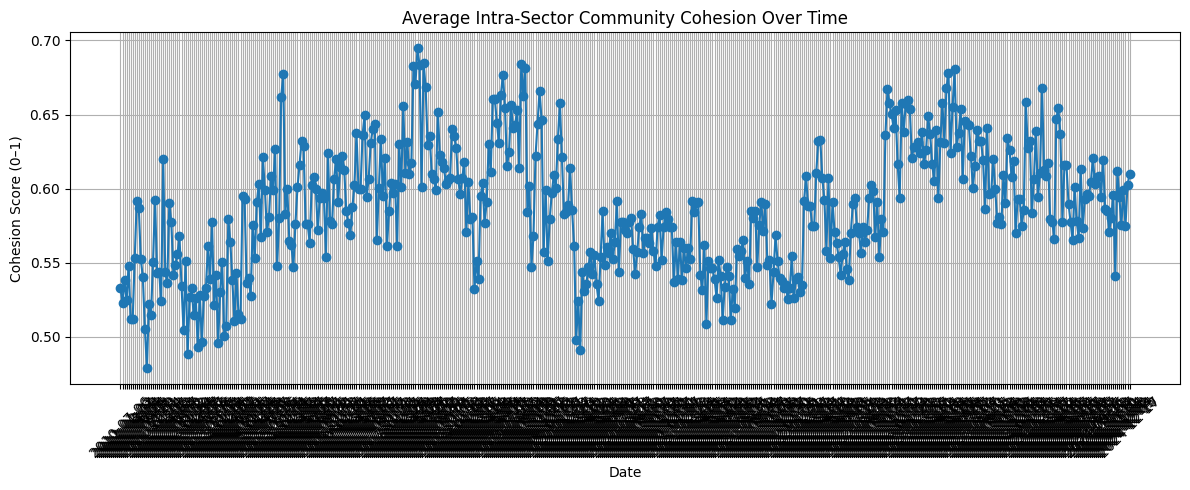

In [45]:
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import os
import json

community_path = "results/communities"
files = sorted([
    f for f in os.listdir(community_path)
    if f.endswith('.json') and len(f) == 15  # YYYY-MM-DD.json
])
dates = [f.replace('.json', '') for f in files]

cohesion_scores = []

for fname in files:
    with open(os.path.join(community_path, fname), 'r', encoding='utf-8') as f:
        community_data = json.load(f)

    # Group stocks by sector
    sector_to_comms = defaultdict(list)
    for stock, comm in community_data.items():
        if stock in sector_map:
            sector_to_comms[sector_map[stock]].append(comm)

    # Compute cohesion: for each sector, % stocks in mode community
    scores = []
    for sector, comms in sector_to_comms.items():
        if len(comms) > 1:  # ignore single-stock sectors
            mode_freq = Counter(comms).most_common(1)[0][1]
            scores.append(mode_freq / len(comms))
    
    # Store average cohesion across sectors for this window
    cohesion_scores.append(np.mean(scores))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(dates, cohesion_scores, marker='o')
plt.xticks(rotation=45)
plt.title("Average Intra-Sector Community Cohesion Over Time")
plt.ylabel("Cohesion Score (0–1)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()



In [46]:

# Step 1: Load community → stocks map for each time window
community_path = "results/communities"
files = sorted(f for f in os.listdir(community_path) if f.endswith('.json'))
dates = [f.replace('.json', '') for f in files]

community_sets = []  # list of {community_id: set(stocks)}
for fname in files:
    with open(os.path.join(community_path, fname), 'r', encoding='utf-8') as f:
        data = json.load(f)

    comm_to_stocks = defaultdict(set)
    for stock, comm in data.items():
        comm_to_stocks[comm].add(stock)
    community_sets.append(comm_to_stocks)

In [47]:
# Step 2: Compute Jaccard similarity between communities in t and t+1
# Track matched community chains
chain_id = 0
chains = {}  # chain_id -> [set of stocks per window]
active_chains = {}  # last_seen_com_id -> chain_id

for t in range(len(community_sets) - 1):
    curr = community_sets[t]
    nxt = community_sets[t + 1]
    matched = set()
    

    for curr_id, curr_stocks in curr.items():
        best_score = 0
        best_next_id = None

        for next_id, next_stocks in nxt.items():
            if (curr_id, next_id) in matched:
                continue
            inter = len(curr_stocks & next_stocks)
            union = len(curr_stocks | next_stocks)
            score = inter / union if union > 0 else 0

            if score > best_score:
                best_score = score
                best_next_id = next_id

        # Accept match if similarity above threshold
        if best_score > 0.5:  # tunable
            if curr_id in active_chains:
                cid = active_chains[curr_id]
            else:
                cid = chain_id
                chains[cid] = []
                chain_id += 1

            chains[cid].append((dates[t], curr_id, curr_stocks))
            active_chains[best_next_id] = cid
            matched.add((curr_id, best_next_id))

# Step 3: Rank chains by length or average Jaccard stability
ranked_chains = sorted(chains.items(), key=lambda x: len(x[1]), reverse=True)

# Print top stable communities
for cid, chain in ranked_chains[:5]:
    print(f"\nCommunity Chain ID {cid} — length {len(chain)}")
    for date, com_id, stocks in chain:
        print(f"{date}: Community {com_id} — {len(stocks)} stocks")



Community Chain ID 30 — length 1644
2018-02-28: Community 77 — 8 stocks
2018-03-05: Community 32 — 12 stocks
2018-03-29: Community 10 — 17 stocks
2018-04-04: Community 20 — 20 stocks
2018-04-04: Community 6 — 10 stocks
2018-04-09: Community 6 — 20 stocks
2018-04-09: Community 9 — 10 stocks
2018-05-03: Community 9 — 9 stocks
2018-05-03: Community 20 — 12 stocks
2018-05-03: Community 6 — 10 stocks
2018-05-08: Community 0 — 9 stocks
2018-05-08: Community 14 — 10 stocks
2018-05-24: Community 67 — 9 stocks
2018-05-24: Community 9 — 9 stocks
2018-05-24: Community 3 — 10 stocks
2018-06-04: Community 9 — 10 stocks
2018-06-04: Community 7 — 9 stocks
2018-06-07: Community 0 — 10 stocks
2018-06-07: Community 2 — 9 stocks
2018-06-07: Community 9 — 10 stocks
2018-06-25: Community 1 — 9 stocks
2018-06-25: Community 9 — 9 stocks
2018-06-25: Community 12 — 10 stocks
2018-07-02: Community 5 — 12 stocks
2018-07-03: Community 9 — 9 stocks
2018-07-09: Community 2 — 9 stocks
2018-07-09: Community 7 — 9 st

In [48]:
from sklearn.metrics import jaccard_score
import pandas as pd

def jaccard(a, b):
    inter = len(a & b)
    union = len(a | b)
    return inter / union if union else 0.0

chain_scores = []

for cid, entries in chains.items():
    jaccards = []
    for i in range(1, len(entries)):
        prev_set = entries[i - 1][2]
        curr_set = entries[i][2]
        jaccards.append(jaccard(prev_set, curr_set))

    avg_jaccard = np.mean(jaccards) if jaccards else 0
    chain_scores.append({
        'chain_id': cid,
        'length': len(entries),
        'avg_jaccard': avg_jaccard,
    })

# Create and sort DataFrame
score_df = pd.DataFrame(chain_scores)
score_df['stability_score'] = score_df['avg_jaccard'] * score_df['length']
score_df = score_df.sort_values(by='stability_score', ascending=False)

print(score_df.head(10))

    chain_id  length  avg_jaccard  stability_score
20        20    1180     0.054234        63.995716
41        41     319     0.112153        35.776816
14        14     928     0.036187        33.581415
3          3     171     0.163648        27.983759
11        11     180     0.113533        20.435878
30        30    1644     0.011565        19.013238
19        19      67     0.260103        17.426931
18        18      63     0.242109        15.252888
25        25      23     0.611343        14.060893
1          1     115     0.071425         8.213852


In [52]:
from collections import Counter
import pandas as pd

def extract_core_stocks(chain_entries, min_frac=0.8, min_core=3):
    all_stocks = [s for _, _, stocks in chain_entries for s in stocks]
    freq = Counter(all_stocks)
    threshold = min_frac * len(chain_entries)
    core = [s for s, cnt in freq.items() if cnt >= threshold]
    # fallback: if core too small, take top‑k most frequent
    if len(core) < min_core:
        core = [s for s, _ in freq.most_common(min_core)]
    return core


# Chain IDs to analyze
chain_ids = [20, 41, 14, 3, 11, 30, 19, 18, 25, 1]

community_summaries = []

for cid in chain_ids:
    entries = chains[cid]
    core = extract_core_stocks(entries, min_frac=0.5)
    community_summaries.append({
        'chain_id': cid,
        'length': len(entries),
        'avg_jaccard': score_df.set_index("chain_id").loc[cid]['avg_jaccard'],
        'stability_score': score_df.set_index("chain_id").loc[cid]['stability_score'],
        'n_core_stocks': len(core),
        'core_stocks': core
    })

summary_df = pd.DataFrame(community_summaries)
summary_df


,chain_id,length,avg_jaccard,stability_score,n_core_stocks,core_stocks
0,20,1180,0.054234,63.995716,3,"[SWK, WRB, BDX]"
1,41,319,0.112153,35.776816,3,"[FCX, EQT, VLO]"
2,14,928,0.036187,33.581415,3,"[PNW, DTE, EIX]"
3,3,171,0.163648,27.983759,3,"[EQT, CVX, BKR]"
4,11,180,0.113533,20.435878,3,"[STZ, JBHT, JCI]"
5,30,1644,0.011565,19.013238,3,"[ANSS, FTNT, AES]"
6,19,67,0.260103,17.426931,3,"[TSLA, FTNT, NFLX]"
7,18,63,0.242109,15.252888,3,"[PHM, BLDR, LEN]"
8,25,23,0.611343,14.060893,15,"[VTRS, MRK, VRTX, INCY, ABT, ABBV, PODD, BDX, ..."
9,1,115,0.071425,8.213852,3,"[NVDA, FRT, KIM]"


In [53]:
stable_communities = []

for row in score_df.itertuples():
    cid = row.chain_id
    entries = chains[cid]
    core_stocks = extract_core_stocks(entries, min_frac=0.8)
    
    stable_communities.append({
        'chain_id': cid,
        'length': row.length,
        'avg_jaccard': row.avg_jaccard,
        'stability_score': row.stability_score,
        'n_core_stocks': len(core_stocks),
        'core_stocks': core_stocks
    })

# Convert to DataFrame for summary
summary_df = pd.DataFrame(stable_communities)
print(summary_df[['chain_id', 'length', 'avg_jaccard', 'stability_score', 'n_core_stocks']])

    chain_id  length  avg_jaccard  stability_score  n_core_stocks
0         20    1180     0.054234        63.995716              3
1         41     319     0.112153        35.776816              3
2         14     928     0.036187        33.581415              3
3          3     171     0.163648        27.983759              3
4         11     180     0.113533        20.435878              3
5         30    1644     0.011565        19.013238              3
6         19      67     0.260103        17.426931              3
7         18      63     0.242109        15.252888              3
8         25      23     0.611343        14.060893              3
9          1     115     0.071425         8.213852              3
10        32      23     0.330470         7.600813              3
11        26      11     0.460000         5.060000              3
12        33       4     1.000000         4.000000              7
13        31       5     0.795455         3.977273              3
14        

In [54]:
pd.set_option('display.max_colwidth', 100)
display(summary_df[['chain_id', 'length', 'avg_jaccard', 'stability_score', 'n_core_stocks', 'core_stocks']])

,chain_id,length,avg_jaccard,stability_score,n_core_stocks,core_stocks
0,20,1180,0.054234,63.995716,3,"[SWK, WRB, BDX]"
1,41,319,0.112153,35.776816,3,"[FCX, EQT, VLO]"
2,14,928,0.036187,33.581415,3,"[PNW, DTE, EIX]"
3,3,171,0.163648,27.983759,3,"[EQT, CVX, BKR]"
4,11,180,0.113533,20.435878,3,"[STZ, JBHT, JCI]"
5,30,1644,0.011565,19.013238,3,"[ANSS, FTNT, AES]"
6,19,67,0.260103,17.426931,3,"[TSLA, FTNT, NFLX]"
7,18,63,0.242109,15.252888,3,"[PHM, BLDR, LEN]"
8,25,23,0.611343,14.060893,3,"[VTRS, MRK, VRTX]"
9,1,115,0.071425,8.213852,3,"[NVDA, FRT, KIM]"


In [55]:
for entry in community_summaries:
    stocks = entry['core_stocks']
    sectors = [sector_map.get(s, 'Unknown') for s in stocks]
    sector_counts = Counter(sectors)
    
    entry['sector_distribution'] = dict(sector_counts)

In [56]:
for entry in community_summaries:
    print(f"\nChain {entry['chain_id']} (Length: {entry['length']} | Core Stocks: {entry['n_core_stocks']})")
    print("Sector Distribution:")
    for sector, count in entry['sector_distribution'].items():
        print(f"  {sector:<30} : {count}")



Chain 20 (Length: 1180 | Core Stocks: 3)
Sector Distribution:
  Industrials                    : 1
  Financial Services             : 1
  Healthcare                     : 1

Chain 41 (Length: 319 | Core Stocks: 3)
Sector Distribution:
  Basic Materials                : 1
  Energy                         : 2

Chain 14 (Length: 928 | Core Stocks: 3)
Sector Distribution:
  Utilities                      : 3

Chain 3 (Length: 171 | Core Stocks: 3)
Sector Distribution:
  Energy                         : 3

Chain 11 (Length: 180 | Core Stocks: 3)
Sector Distribution:
  Consumer Defensive             : 1
  Industrials                    : 2

Chain 30 (Length: 1644 | Core Stocks: 3)
Sector Distribution:
  Technology                     : 2
  Utilities                      : 1

Chain 19 (Length: 67 | Core Stocks: 3)
Sector Distribution:
  Consumer Cyclical              : 1
  Technology                     : 1
  Communication Services         : 1

Chain 18 (Length: 63 | Core Stocks: 3)
Sector D

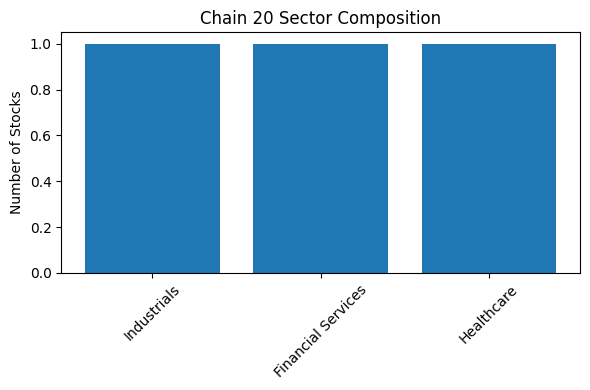

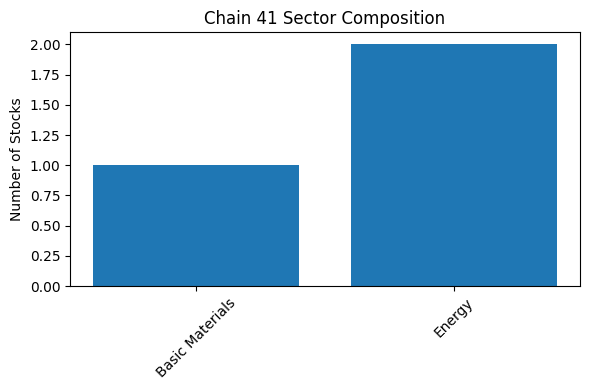

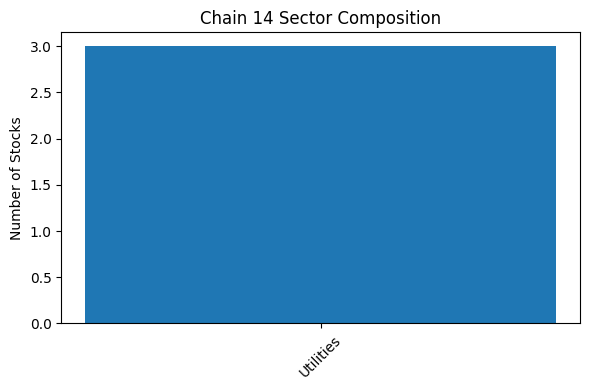

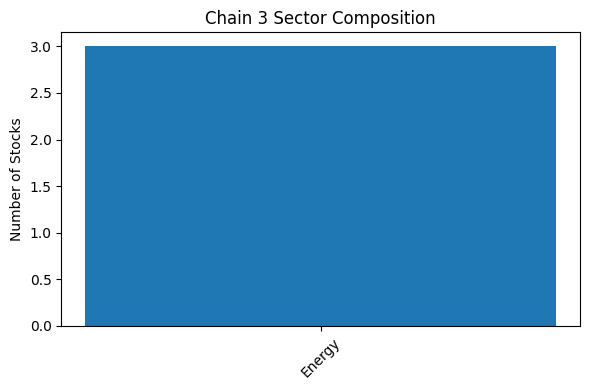

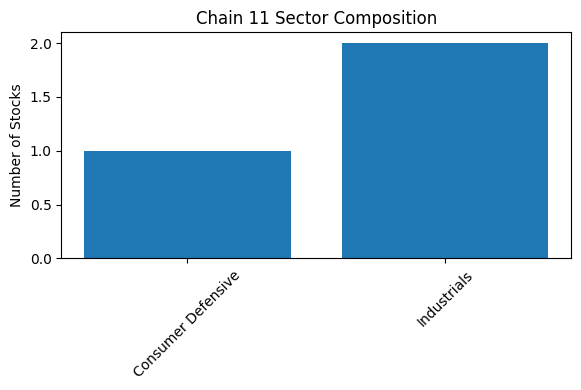

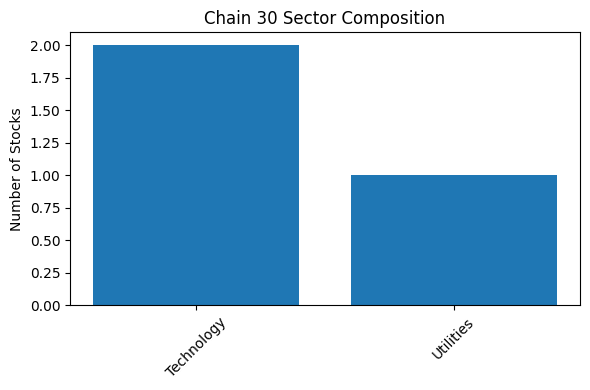

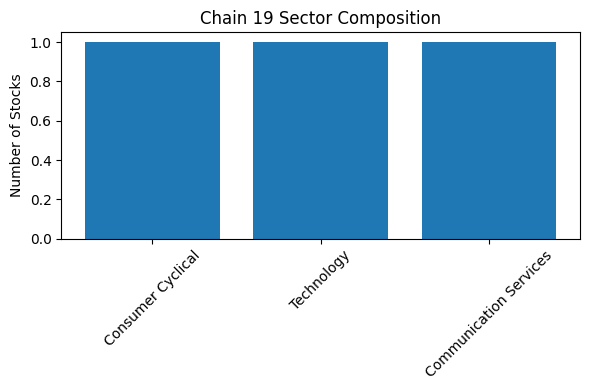

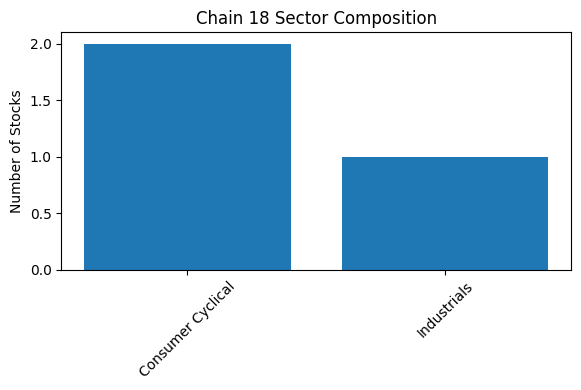

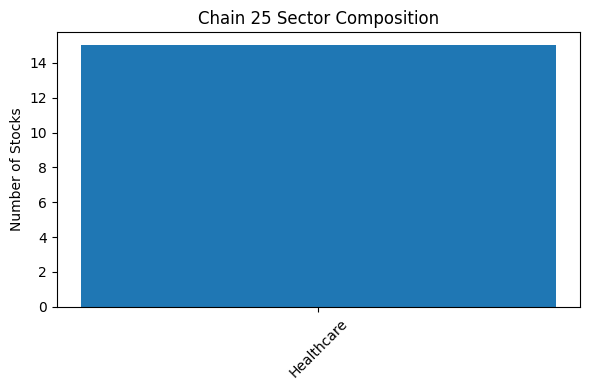

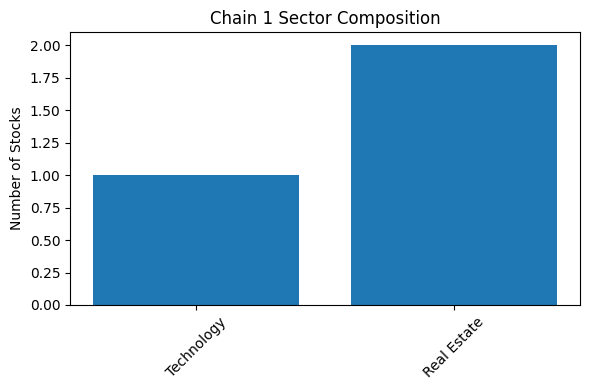

In [57]:
for entry in community_summaries:
    sector_counts = entry['sector_distribution']
    
    plt.figure(figsize=(6,4))
    plt.bar(sector_counts.keys(), sector_counts.values())
    plt.xticks(rotation=45)
    plt.title(f"Chain {entry['chain_id']} Sector Composition")
    plt.ylabel("Number of Stocks")
    plt.tight_layout()
    plt.show()